/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:285: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diagonal(pcov))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide 

[0.10041074]


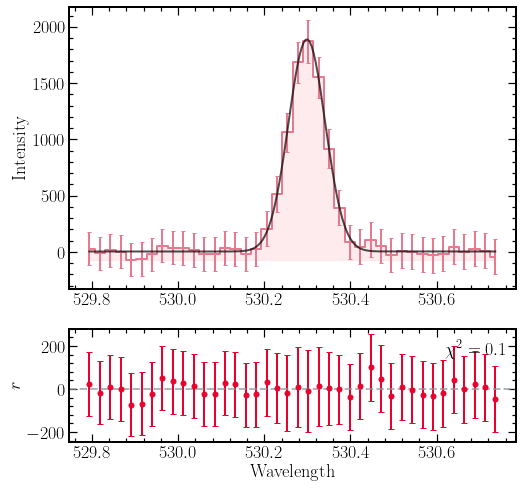

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import astropy.units as u
from astropy.nddata import StdDevUncertainty
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from specutils import Spectrum1D
from specutils.manipulation import SplineInterpolatedResampler
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
from scipy.interpolate import interp1d
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

def fit_spectra(image, err, wvl, orders, flatfields, wavelength_slices, intensity_matrices,intensity_err_matrices,
                ypix_slice, cont_slice_1, cont_slice_2,nbin=5,plot_fit=False):
    
    images_sliced = [image[ypix_slice, wavelength_slice_]/flatfield_[:,np.newaxis] \
                     for (wavelength_slice_,flatfield_) in zip(wavelength_slices,flatfields)]
    errs_sliced = [err[ypix_slice, wavelength_slice_]/flatfield_[:,np.newaxis] \
                     for (wavelength_slice_,flatfield_) in zip(wavelength_slices,flatfields)]
    
    intensity_matrices = np.array(intensity_matrices)
    intensity_err_matrices = np.array(intensity_err_matrices)

    if (nbin == 1) or (nbin is None):
        pass
    else:
        for ii in range(3):
            images_sliced[ii] = np.nanmean(images_sliced[ii].reshape(-1,nbin,images_sliced[ii].shape[1]),axis=1)
            errs_sliced[ii] = np.sqrt(np.nanmean((errs_sliced[ii]**2).reshape(-1,nbin,images_sliced[ii].shape[1]),axis=1))/np.sqrt(nbin)

    images_sliced_interp = np.array(images_sliced)
    errs_sliced_interp = np.array(errs_sliced)

    wvls_sliced = [wvl[wavelength_slice_]/order_ for \
                   (wavelength_slice_ , order_)in zip(wavelength_slices, orders)]
    
    for ii in range(3):
        wvl_grid = wvls_sliced[ii]*u.nm
        wvl_grid_interp = wvls_sliced[2]*u.nm
        for jj in range(images_sliced[ii].shape[0]):
            interp_spline = SplineInterpolatedResampler()
            spec_grid = images_sliced[ii][jj,:]*u.adu
            spec_err = StdDevUncertainty(errs_sliced[ii][jj,:],unit=u.adu)
            if (wvl_grid[1] - wvl_grid[0]) < 0:
                input_spec = Spectrum1D(flux=np.flip(spec_grid),spectral_axis=np.flip(wvl_grid),uncertainty=np.flip(spec_err))
            else:
                input_spec = Spectrum1D(flux=spec_grid,spectral_axis=wvl_grid,uncertainty=spec_err)
            interp_spec = interp_spline(input_spec,wvl_grid_interp)
            images_sliced_interp[ii,jj,:] = interp_spec.flux.value
            errs_sliced_interp[ii,jj,:] = interp_spec.uncertainty.array

            # interp_func = interp1d(wvls_sliced[ii], images_sliced[ii],
            #                     kind="cubic",axis=1,fill_value="extrapolate")
            # images_sliced_interp[ii,:,:] = interp_func(wvls_sliced[2])

            # # interp_func_err = interp1d(wvls_sliced[ii], errs_sliced[ii],
            # #                     kind="linear",axis=1,fill_value="extrapolate")
            # errs_sliced_interp[ii,:,:] = interp_func_err(wvls_sliced[2])
        
        
    image_combined = np.nanmean(images_sliced_interp/intensity_matrices[:,:,np.newaxis]*intensity_matrices[2,:,np.newaxis],axis=0)[:,5:-5]
    err_f1 = intensity_matrices[2,:]/(3*intensity_matrices[0,:])
    err_f2 = intensity_matrices[2,:]/(3*intensity_matrices[1,:])
    err_f3 = 1./3
    err_f4 = - images_sliced_interp[0,:,:]*intensity_matrices[2,:,np.newaxis]/(3*intensity_matrices[0,:,np.newaxis]**2)
    err_f5 = - images_sliced_interp[1,:,:]*intensity_matrices[2,:,np.newaxis]/(3*intensity_matrices[1,:,np.newaxis]**2)
    err_f6 = 1./3*(images_sliced_interp[0,:,:]/intensity_matrices[0,:,np.newaxis]+ \
                    images_sliced_interp[1,:,:]/intensity_matrices[1,:,np.newaxis]) 
    
    err_combined = np.sqrt((err_f1[:,np.newaxis]*errs_sliced_interp[0,:,:])**2 + \
                            (err_f2[:,np.newaxis]*errs_sliced_interp[1,:,:])**2 + \
                            (err_f3*errs_sliced_interp[2,:,:])**2 + \
                            (err_f4*intensity_err_matrices[0,:,np.newaxis])**2 + \
                            (err_f5*intensity_err_matrices[1,:,np.newaxis])**2 + \
                            (err_f6*intensity_err_matrices[2,:,np.newaxis])**2)
    err_combined = err_combined[:,5:-5]

    fit_params = np.zeros((5,image_combined.shape[0]))
    fit_errs = np.zeros((5,image_combined.shape[0]))

    wvl_sliced = wvls_sliced[2][5:-5]

    for ii in range(image_combined.shape[0]):
        if ii == 32:
            plot_fit_real = plot_fit
        else:
            plot_fit_real = False
        fit_params[:,ii], fit_errs[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_combined[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_combined[ii,:],
                                err_combined[ii,:],plot_fit=plot_fit_real)

    return fit_params, fit_errs


def fit_spectra_single(cont_wvl, cont_int, wvl, int, err, plot_fit=False):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)

    fit_model = SpectrumFitSingle(data=int_res,err=err, wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=0.1)

    try:
        fit_model.run_lse(absolute_sigma=False)
    except:
        pass
    if plot_fit:
        fit_model.plot(plot_params=False)
        print(fit_model.fwhm_fit)

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0],
                      fit_model.int_cont_fit, cont_fit_poly(fit_model.line_wvl_fit[0])]), \
            np.array([fit_model.line_wvl_err[0], fit_model.int_total_err[0], fit_model.fwhm_err[0],
                    fit_model.int_cont_err, 0])


green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_63rd.h5", 'r') as hf:
    flatfield_1d_FeXIV_63rd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_62nd.h5", 'r') as hf:
    flatfield_1d_FeXIV_62nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_61st.h5", 'r') as hf:
    flatfield_1d_FeXIV_61st = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_51st.h5", 'r') as hf:
    flatfield_1d_FeX_51st = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_53rd.h5", 'r') as hf:
    flatfield_1d_FeX_53rd = hf['flatfield_1d'][:]


with h5py.File("../../sav/Eclipse/FitResults/FeXIV_61.h5","r") as hf:
    FeXIV_61_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_61_intensity_err = np.flip(hf["green_fit_matrix_ext_err"][1,:])
    FeXIV_61_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_61_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_62.h5","r") as hf:
    FeXIV_62_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_62_intensity_err = np.flip(hf["green_fit_matrix_ext_err"][1,:])
    FeXIV_62_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_62_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5","r") as hf:
    FeXIV_63_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_63_intensity_err = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_63_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_63_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

FeXIV_order = [61,62,63]
FeXIV_flatfields = [flatfield_1d_FeXIV_61st,flatfield_1d_FeXIV_62nd,flatfield_1d_FeXIV_63rd]
FeXIV_xslices = [slice(1010,1060),slice(685,735),slice(345,395)]


starttime_green_ext = datetime(2017,8,21,17,45,36)
green_fit_matrix_ext = np.full((5,350,188),np.nan,dtype=np.float64)
green_fit_matrix_ext_err = np.full((5,350,188),np.nan,dtype=np.float64)
green_fit_filename_index = np.full(188,np.nan,dtype=np.int32)
# for ii, row_ in totality_green_df_ext.iterrows(): 
#     date_obs = row_["date-obs"]
#     exptime = np.float64(row_["exptime"])
#     readout_noise = np.float64(row_["ronoise"])

#     time_difference = date_obs - starttime_green_ext
#     startindex = int(time_difference.total_seconds()*2)
#     endindex = startindex + int(exptime*2)

#     green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
#     green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data
#     green_frame_noise_ = np.sqrt(green_frame_.data*exptime + readout_noise**2)/exptime

#     FeXIV_fit_, FeXIV_fit_err_ = fit_spectra(green_frame_.data/exptime,
#     green_frame_noise_, green_frame_wavelength_/10., FeXIV_order, FeXIV_flatfields, FeXIV_xslices,
#     [FeXIV_61_intensity[:,startindex],FeXIV_62_intensity[:,startindex],FeXIV_63_intensity[:,startindex]],
#     [FeXIV_61_intensity_err[:,startindex],FeXIV_62_intensity_err[:,startindex],FeXIV_63_intensity_err[:,startindex]],
#     slice(0,None), slice(0,10),slice(30,40), nbin=None)

#     green_fit_matrix_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
#     green_fit_matrix_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
#     green_fit_filename_index[startindex:endindex] = ii

# green_fit_matrix_ext = np.flip(green_fit_matrix_ext,axis=(1,2))
# green_fit_matrix_ext_err = np.flip(green_fit_matrix_ext_err,axis=(1,2))
# green_fit_filename_index = np.flip(green_fit_filename_index)

green_fit_matrix_bin_ext = np.full((5,70,188),np.nan,dtype=np.float64)
green_fit_matrix_bin_ext_err = np.full((5,70,188),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])
    readout_noise = np.float64(row_["ronoise"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data
    green_frame_noise_ = np.sqrt(green_frame_.data*exptime + readout_noise**2)/exptime

    if row_["file"] == "TotalitySequenceGreen_22717(2)_l1.fit":
        plot_fit = True
    else:
        plot_fit = False

    FeXIV_fit_, FeXIV_fit_err_ = fit_spectra(green_frame_.data/exptime,
    green_frame_noise_,green_frame_wavelength_/10., FeXIV_order, FeXIV_flatfields, FeXIV_xslices,
    [FeXIV_61_intensity_bin[:,startindex],FeXIV_62_intensity_bin[:,startindex],FeXIV_63_intensity_bin[:,startindex]],
    [FeXIV_61_intensity_bin_err[:,startindex],FeXIV_62_intensity_bin_err[:,startindex],FeXIV_63_intensity_bin_err[:,startindex]],
    slice(0,None), slice(0,10),slice(30,40), nbin=5,plot_fit=plot_fit)

    green_fit_matrix_bin_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
    green_fit_matrix_bin_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
green_fit_matrix_bin_ext = np.flip(green_fit_matrix_bin_ext,axis=(1,2))
green_fit_matrix_bin_ext_err = np.flip(green_fit_matrix_bin_ext_err,axis=(1,2))

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_add3orders.h5", 'w') as hf:
    df_green_fit_matrix_ext = hf.create_dataset("green_fit_matrix_ext",  data=green_fit_matrix_ext)
    df_green_fit_matrix_ext_err = hf.create_dataset("green_fit_matrix_ext_err",  data=green_fit_matrix_ext_err)
    df_green_fit_matrix_bin_ext = hf.create_dataset("green_fit_matrix_bin_ext",  data=green_fit_matrix_bin_ext)
    df_green_fit_matrix_bin_ext_err = hf.create_dataset("green_fit_matrix_bin_ext_err",  data=green_fit_matrix_bin_ext_err)
    df_green_fit_filename_index = hf.create_dataset("green_fit_filename_index",  data=green_fit_filename_index)
    df_green_fit_matrix_ext.attrs["description"] = "wvl;int;fwhm;cont_fit;cont_bg_poly"



# only test on Fe XIV, Fe X codes are still copied from the ext_fit_all.py
# FeX_order = [51,52,53]
# FeX_flatfields = [flatfield_1d_FeX_51st,flatfield_1d_FeX_52nd,flatfield_1d_FeX_53rd]
# FeX_xslices = [slice(205,255),slice(602,652),slice(1025,1075)]

# for order,flatfield_1d,FeX_xslice in zip(FeX_order,FeX_flatfields,FeX_xslices):
#     starttime_red_ext = datetime(2017,8,21,17,45,36)
#     red_fit_matrix_ext = np.full((4,350,176),np.nan,dtype=np.float64)
#     red_fit_matrix_ext_err = np.full((4,350,176),np.nan,dtype=np.float64)
#     red_fit_filename_index = np.full(176,np.nan,dtype=np.int32)
#     for ii, row_ in totality_red_df_ext.iterrows(): 
#         date_obs = row_["date-obs"]
#         exptime = np.float64(row_["exptime"])

#         time_difference = date_obs - starttime_red_ext
#         startindex = int(time_difference.total_seconds()*2)
#         endindex = startindex + int(exptime*2)

#         red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
#         red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

#         FeX_fit_, FeX_fit_err_ = fit_spectra(red_frame_.data/flatfield_1d[:,np.newaxis]/exptime,
#         red_frame_wavelength_/order/10., FeX_xslice, slice(0,None), 
#                         slice(0,10),slice(40,50), nbin=None)

#         red_fit_matrix_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
#         red_fit_matrix_ext_err[:,:,startindex:endindex] = FeX_fit_err_[:,:,np.newaxis]
#         red_fit_filename_index[startindex:endindex] = ii

#     red_fit_matrix_ext = np.flip(red_fit_matrix_ext,axis=(1,2))
#     red_fit_matrix_ext_err = np.flip(red_fit_matrix_ext_err,axis=(1,2))
#     red_fit_filename_index = np.flip(red_fit_filename_index)

#     red_fit_matrix_bin_ext = np.full((4,70,176),np.nan,dtype=np.float64)
#     red_fit_matrix_bin_ext_err = np.full((4,70,176),np.nan,dtype=np.float64)
#     for ii, row_ in totality_red_df_ext.iterrows(): 
#         date_obs = row_["date-obs"]
#         exptime = np.float64(row_["exptime"])

#         time_difference = date_obs - starttime_red_ext
#         startindex = int(time_difference.total_seconds()*2)
#         endindex = startindex + int(exptime*2)

#         red_frame_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=0,unit="adu")
#         red_frame_wavelength_ = CCDData.read(os.path.join(red_path,row_["file"]),hdu=2,unit="adu").data

#         FeX_fit_, FeX_fit_err_ = fit_spectra(red_frame_.data/flatfield_1d[:,np.newaxis]/exptime,
#         red_frame_wavelength_/order/10., FeX_xslice, slice(0,None), 
#                         slice(0,10),slice(40,50), nbin=5, plot_fit=False)

#         red_fit_matrix_bin_ext[:,:,startindex:endindex] = FeX_fit_[:,:,np.newaxis]
#         red_fit_matrix_bin_ext_err[:,:,startindex:endindex] = FeX_fit_err_[:,:,np.newaxis]
#     red_fit_matrix_bin_ext = np.flip(red_fit_matrix_bin_ext,axis=(1,2))
#     red_fit_matrix_bin_ext_err = np.flip(red_fit_matrix_bin_ext_err,axis=(1,2))

#     with h5py.File("../../sav/Eclipse/FitResults/FeX_{:d}.h5".format(order), 'w') as hf:
#         df_red_fit_matrix_ext = hf.create_dataset("red_fit_matrix_ext",  data=red_fit_matrix_ext)
#         df_red_fit_matrix_ext_err = hf.create_dataset("red_fit_matrix_ext_err",  data=red_fit_matrix_ext_err)
#         df_red_fit_matrix_bin_ext = hf.create_dataset("red_fit_matrix_bin_ext",  data=red_fit_matrix_bin_ext)
#         df_red_fit_matrix_bin_ext_err = hf.create_dataset("red_fit_matrix_bin_ext_err",  data=red_fit_matrix_bin_ext_err)
#         df_red_fit_filename_index = hf.create_dataset("red_fit_filename_index",  data=red_fit_filename_index)
#         df_red_fit_matrix_ext.attrs["description"] = "wvl;int;fwhm;cont"



